_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [356]:
import sys, time
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm

plt.rcParams.update({'font.size':24, 'image.origin': 'lower', 'xtick.minor.visible': True, 'ytick.minor.visible': True, 'lines.linewidth': 2.4, 'figure.facecolor': 'none', 'axes.facecolor': 'white'})
np.set_printoptions(threshold=sys.maxsize)

In [357]:
#file_number = 15
#file_name = "1dmockanderrors{:d}".format(file_number)
file_name = "240802134128_altered1d"
file_type = ".csv"

target, uncertainties = cs.open_dataset(file_name, ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [358]:
#target = cs.generate_interferogram(200, 200e-6, 3e12, 0.1e12, 1.0)
#uncertainties = np.ones_like(interferogram)

In [359]:
reduced_points = 8
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
idx = np.arange(len(target))

In [360]:
start_time = time.time()

detectors = np.array([], dtype= int)

new_detector = np.argmax(np.abs(target)) # Without any samples, CS cannot find any frequencies so all amplitudes will go to zero. DP wants to locate the point that is furthest away from this zero line. Hence, this is a sensible way to intitalise the loop.
detectors = np.append(detectors, new_detector)

for n in range(1,reduced_points):
    samples = np.full_like(target, np.nan)
    samples[detectors] = target[detectors]
    result = cs.compressed_sensing(samples, regularization_coeffient, ignore_mean= False, dct_type= 1)

    new_detector = np.argsort(np.abs(target -result))[::-1] # argsort sorts from smallest to largest but I want largest to smallest
    new_detector = np.setdiff1d(new_detector, detectors, assume_unique= True)[0] # pick the first (largest) item
    detectors = np.append(detectors, new_detector)

samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient, ignore_mean= False, dct_type= 1)

end_time = time.time()
print(end_time -start_time)

0.024209260940551758


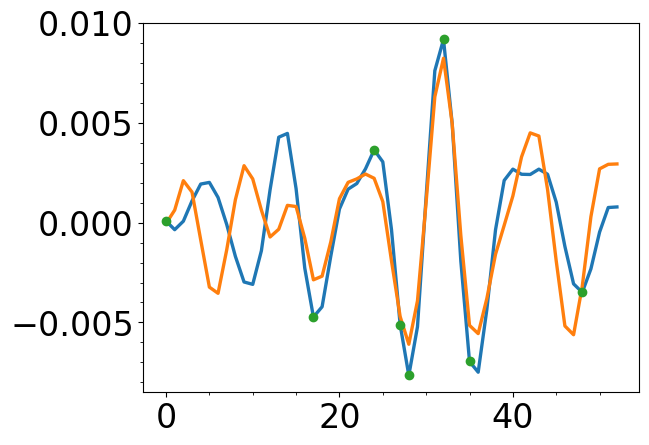

0.016938799148614937


In [361]:
plt.plot(idx, target)
plt.plot(idx, result)
plt.plot(idx[detectors], target[detectors], marker= "o", linestyle= "none")
plt.show()

print(cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient= regularization_coeffient))

In [362]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)
score = cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient)

cs.append_array_to_csv(detectors, optlocs_file)
print(score)

0.016938799148614937


In [363]:
print(*detectors, sep= ",")

32,48,35,24,17,28,0,27


## FWHM graph

In [364]:
regularization_coeffient = 1e-3
max_samples = 100

array_length = 200
pixel_pitch = 200e-6
FWHMs = np.arange(0.05e12, 6e12, 0.05e12)
central_freq = 3e12
theta = 1.0
norm = 1 #The interferogram is defined to peak at 1. Some weird stuff happens when you change the normalisation. I think the distortion happens because of poor lasso convergence (when norm is small) and quantisation (when norm is large).

scores = np.full((max_samples, len(FWHMs)), np.nan)

for m, FWHM in tqdm(enumerate(FWHMs)):
    interferogram = cs.generate_interferogram(array_length, pixel_pitch, central_freq, FWHM, theta)
    uncertainty = np.ones_like(interferogram)
    interferogram /= norm

    detectors, _ = cs.douglas_peucker(max_samples, interferogram, uncertainty, regularization_coeffient= regularization_coeffient)
    interferogram *= norm

    for n in range(max_samples):
        scores[n, m] = cs.evaluate_score(detectors[:n+1], interferogram, uncertainty, regularization_coeffient= regularization_coeffient, domain= "IDCT")


0it [00:00, ?it/s]

119it [04:04,  2.05s/it]


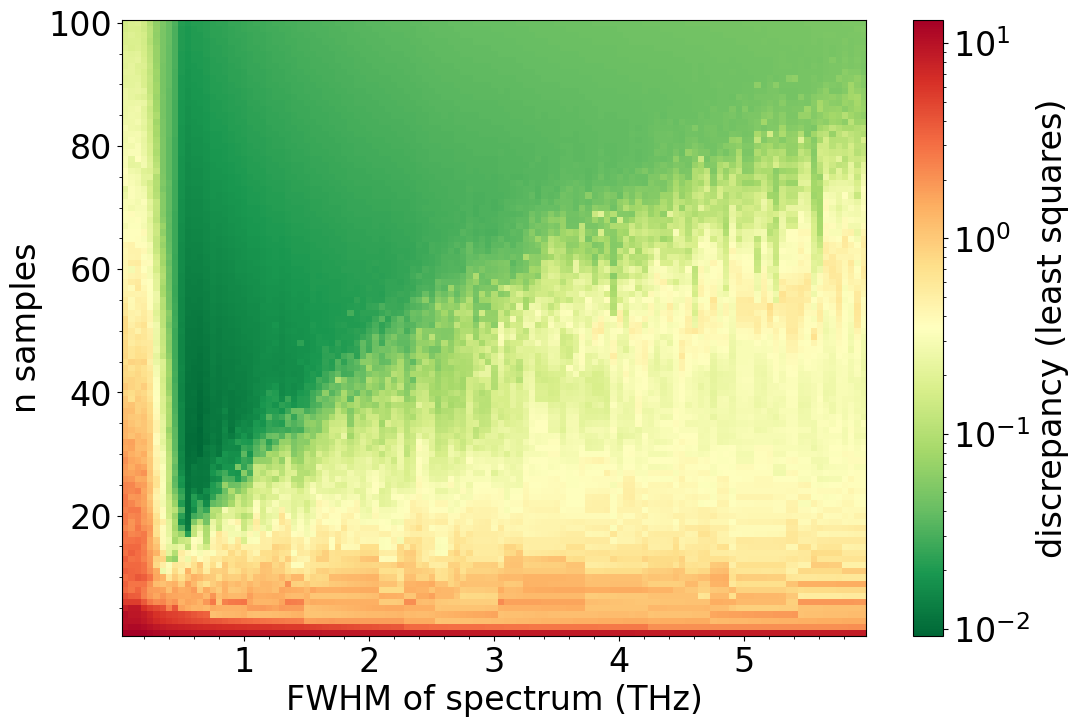

In [365]:
fig, axs = plt.subplots(1, 1, figsize= (12, 8))

im = axs.imshow(scores,
                aspect= "auto",
                interpolation= "none",
                norm= "log",
                cmap= "RdYlGn_r",
                extent= ((1.5*FWHMs[0]-0.5*FWHMs[1]) *1e-12, (1.5*FWHMs[-1]-0.5*FWHMs[-2]) *1e-12, 0.5, max_samples +0.5))

axs.set(xlabel= "FWHM of spectrum (THz)", ylabel= "n samples")

fig.colorbar(im, label= "discrepancy (least squares)")
plt.show()

0.9047171590170833 0.7711608097373592 1.2549208200885753


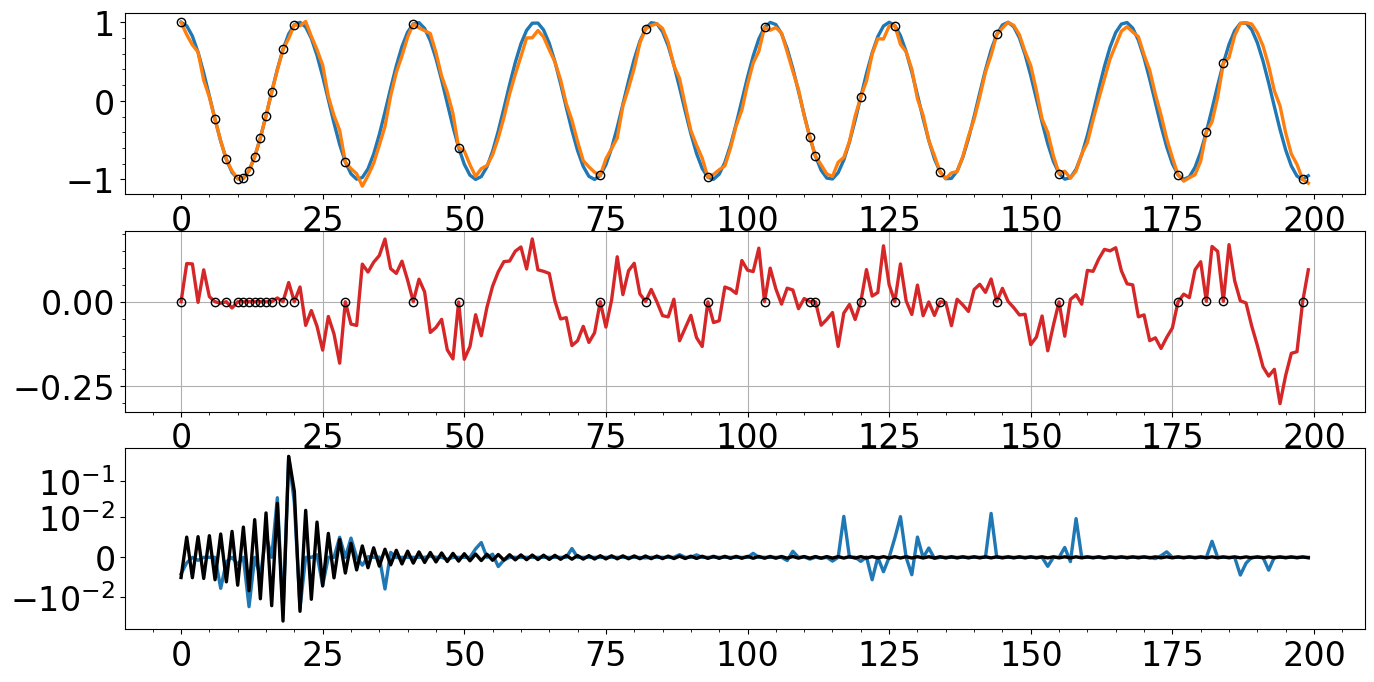

In [411]:
FWHM = 0.01e12
norm = 1
regularization_coeffient = 1e-4

interferogram = cs.generate_interferogram(array_length, pixel_pitch, central_freq, FWHM, theta)

t = np.linspace(0, 1, len(interferogram))
interferogram = np.cos(60*t)

interferogram_DCT = spfft.dct(interferogram, norm= "forward", type= 1)
interferogram = spfft.idct(interferogram_DCT, norm= "forward", type= 1)
uncertainty = np.ones_like(interferogram)

interferogram /= norm #np.linalg.norm(interferogram)
detectors, _ = cs.douglas_peucker(30, interferogram, uncertainty, regularization_coeffient= regularization_coeffient)

interferogram *= norm
samples = np.full_like(interferogram, np.nan)
samples[detectors] = interferogram[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)
DCT = cs.compressed_sensing(samples, regularization_coeffient, domain= "DCT")

fig, axs = plt.subplots(3, 1, figsize= (16, 8))

axs[0].plot(interferogram)
axs[0].plot(result)
axs[0].plot(samples, linestyle= "none", marker= "o", markeredgecolor= "k", markerfacecolor= "none")

regression = interferogram -result
axs[1].plot(regression, color= "tab:red")
axs[1].plot(detectors, regression[detectors], linestyle= "none", marker= "o", markeredgecolor= "k", markerfacecolor= "none")
axs[1].grid(True)

axs[2].plot(DCT)
axs[2].plot(interferogram_DCT, color= "black")
axs[2].set_yscale("symlog", linthresh= 1e-2)
print(np.linalg.norm(interferogram_DCT, ord= 1), np.linalg.norm(DCT, ord= 1), np.linalg.norm(interferogram -result))

plt.show()

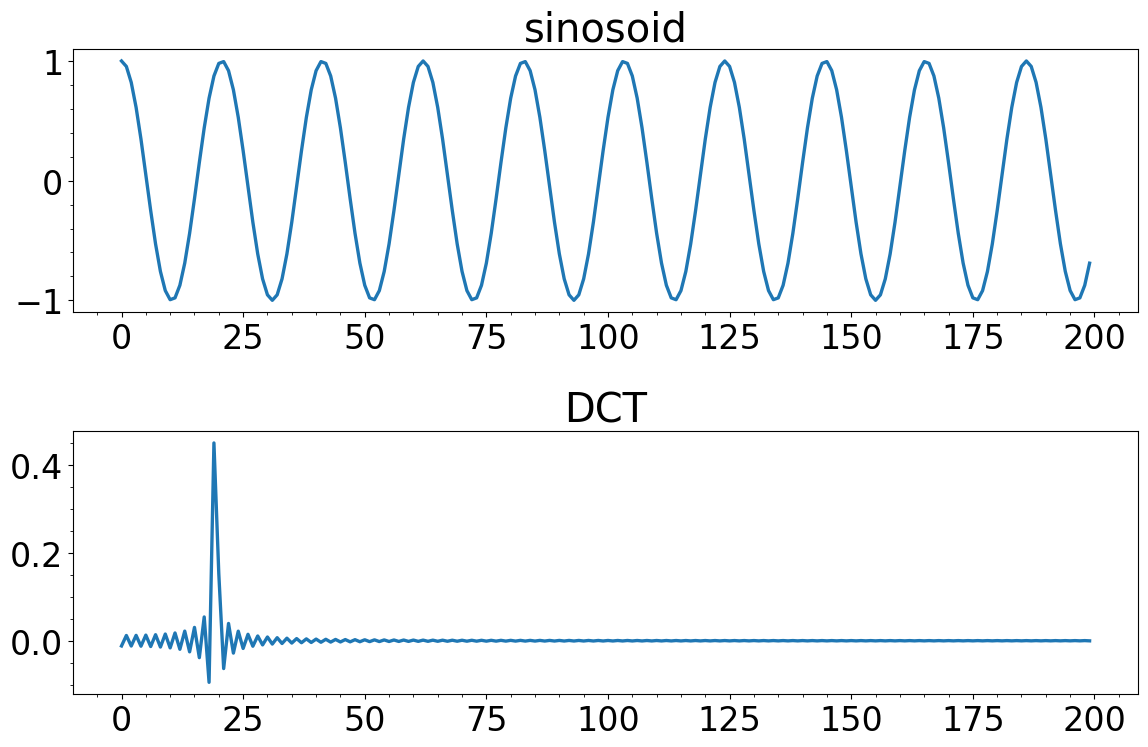

In [416]:
t = np.linspace(0, 1, 200)
interferogram = np.cos(60.5*t)

interferogram_DCT = spfft.dct(interferogram, norm= "forward", type= 1)

fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(interferogram)
axs[0].set(title= "sinosoid")
axs[1].plot(interferogram_DCT)
axs[1].set(title= "DCT")

plt.tight_layout()
plt.show()

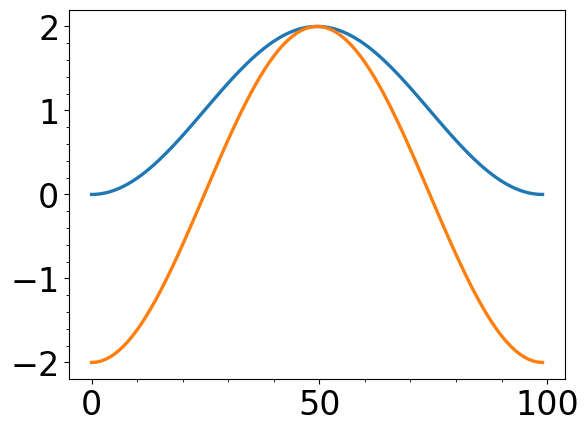

In [367]:
a, b = np.zeros(100), np.zeros(100)

a[0] = 1.
a[2] = -0.5
at = spfft.idct(a, type= 1, norm= "forward")

b[2] = -1
bt = spfft.idct(b, type= 1, norm= "forward")

plt.plot(at)
plt.plot(bt)
plt.show()